In [1]:
import matplotlib.pyplot as plt

from fitting import create_ensemble, load_data, create_datasets
import torch

import sys
sys.path.append("../")

labels = ["x (mm)", r"$p_x$ (mrad)","y (mm)",r"$p_y$ (mrad)","z (mm)",r"$p_z$ (mrad)"]

tkwargs = {"dtype": torch.float}
save_dir = "double_small_emittance_case_cov_term_small_energy_spread/"
quad_strengths, image_data, bins, xx,_ = load_data()
xx = torch.stack(xx)
train_dset = torch.load(save_dir + "/train.dset")
test_dset = torch.load(save_dir + "/test.dset")

bin_width = bins[1] - bins[0]
bandwidth = bin_width / 2


ensemble = create_ensemble(bins, bandwidth)

from torchensemble.utils import io
io.load(ensemble, save_dir)

n_particles = 1000000
for ele in ensemble:
    ele.beam.set_base_beam(
        ele.beam.base_dist,
        n_particles,
        p0c=torch.tensor(10.0e6)
    )

ensemble.cuda();

/global/homes/r/rroussel/.conda/envs/phase_space_reconstruction/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/global/homes/r/rroussel/.conda/envs/phase_space_reconstruction/lib/python3.10/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [2]:
import numpy as np
from scipy.ndimage import median_filter, gaussian_filter

def get_contour_levels(image, quantiles):
    # smooth image
    
    # get cdf of densities
    vmax = image.max()
    test_levels = np.linspace(0, vmax, 1000)
    
    # for each level calculate the fractional sum
    total = image.sum()
    sums = []
    for ele in test_levels:
        sums += [np.where(image >= ele, image, 0.0).sum() / total]
    sums = np.array(sums)

    # calculate levels
    levels = []
    for ele in quantiles[::-1]:
        diff = sums - ele
        levels += [test_levels[np.where(np.diff(np.sign(diff)))]]
        
    return np.array(levels).flatten()

torch.Size([6, 1, 200, 200])


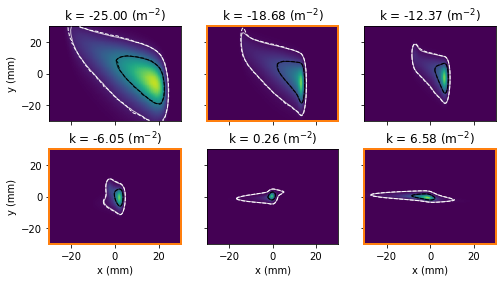

In [6]:
s = torch.arange(0,18,3)
xx_mm = xx*1e3
with torch.no_grad():
    predictions = []
    for i in range(10,20):
        p, _,_ = ensemble[i](quad_strengths[s].cuda())
        predictions += [p]
        
mean_predictions = torch.stack(predictions).mean(dim=0)
print(mean_predictions.shape)

fig, axes = plt.subplots(2,int(len(mean_predictions) / 2), sharex="all", sharey="all", gridspec_kw={"hspace":0.3})
ax = axes.flatten()

for ele in axes[:,0]:
    ele.set_ylabel("y (mm)")
for ele in axes[1,:]:
    ele.set_xlabel("x (mm)")

fig.set_size_inches(8,4)

q = [0.5,0.95]
colors = ["white","black"]
for i in range(len(s)):
    vmax = torch.stack((image_data[s[i],0].cpu(), mean_predictions[i][0].cpu())).max()
    
    image = image_data[s[i],0].cpu().detach().T
    pred = mean_predictions[i][0].cpu().detach().T
    
    smoothed_image = gaussian_filter(image,2,truncate=10.0)
    smoothed_pred = gaussian_filter(pred,2,truncate=10.0)
    
    image_contours = get_contour_levels(smoothed_image, q)
    pred_contours = get_contour_levels(smoothed_pred, q)

    # plot images
    ax[i].set_title(f"k = {float(quad_strengths[s[i]].cpu()):.2f} (m$^{{-2}}$)")
    ax[i].pcolor(*xx_mm, smoothed_pred,
                    vmin=0,vmax=vmax
                    )    
    
    # add contours
    c2 = ax[i].contour(*xx_mm, smoothed_image, levels=image_contours,
                             colors=colors,linestyles="dashed",
                            zorder=3,linewidths=1)
    c3 = ax[i].contour(*xx_mm, smoothed_pred, levels=pred_contours,
                         colors=colors,#linestyles="dashed",
                        zorder=4,linewidths=1,alpha=0.75)
    
    
    if s[i] % 2:
        for a in [ax[i]]:
            for spine in a.spines.values():
                spine.set_edgecolor('C1')
                spine.set_linewidth(2)

fig.savefig("supp_raw_image_comparison.png",dpi=300)

In [4]:
from visualization import add_image, add_projection, add_image_projection
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib.axes import SubplotBase

print(all_images.shape)
plot_bins = bins
#plot_bins = plot_bins * 1e3

linewidth=1.0

idxs = np.array([1,6,11,16,19])
plot_bins = bins
extent = 25
im_vmax = all_images.max().cpu() * 0.325
print(idxs)

fig,ax = plt.subplots(3,len(idxs), sharex="all",sharey="all")
fig.subplots_adjust(wspace=0.1, right=0.975, top=0.9, hspace=0.1)
fig.set_size_inches(8,4)

for j, idx in enumerate(idxs):
    ax[0][j].pcolor(xx[0]*1e3,xx[1]*1e3, all_images[idx,0].cpu(),vmax=im_vmax*1.1)
    ax[1][j].pcolor(xx[0]*1e3,xx[1]*1e3, model_pred[idx,0].cpu(),vmax=im_vmax*1.1)

    ax[0][j].collections[0].set_rasterized(True)

    colors = ["C0","C1"]
    axa = ax[2][j].twinx()
    axb = ax[2][j].twiny()

    for h, ele in enumerate([all_images.cpu(), model_pred.cpu()]):
        axa = add_image_projection(axa, ele[idx], plot_bins, "x", scale_x=1e3,c=colors[h])
        axb = add_image_projection(axb, ele[idx], plot_bins, "y", scale_x=1e3, c=colors[h])



    for ele in [axa,axb]:
        for line in ele.get_lines():
            line.set(linewidth=linewidth)
        ele.get_lines()[0].set(zorder=0)

    axa.set_ylim(0, axa.get_ylim()[-1]*3.0)
    axb.set_xlim(0, axb.get_xlim()[-1]*3.0)
    axa.set_yticks([])
    axb.set_xticks([])


    ax[0][j].set_xlim(-extent,extent)
    ax[0][j].set_ylim(-extent,extent)
    ax[1][j].set_ylim(-extent,extent)

    if idxs[j] % 2 == 1:
        for a in [*ax[:,j], axb]:
            for spine in a.spines.values():
                spine.set_edgecolor('red')
                spine.set_linewidth(2)

    ax[0][j].set_title(f"k = {all_k[idxs[j],0]:2.3} $m^{{-2}}$")

# set rasterization for pcolor
for k in range(ax.shape[-1]):
    ax[0,k].collections[0].set_rasterized(True)
    ax[1,k].collections[0].set_rasterized(True)

for a in ax[-1,:]:
    a.set_xlabel('x (mm)')
    #a.set_xticks([-7,0,7])

for a in ax[:,0]:
    a.set_ylabel("y (mm)")
    #a.set_yticks([-7,0,7])


print(pred_initial_beams[0].z.std())
print(pred_initial_beams[0].pz.std())


#fig.tight_layout()

fig.savefig("synth_supp.svg")
fig.savefig("synth_supp.png", dpi=300)

ModuleNotFoundError: No module named 'visualization'

In [ ]:
pairs = [["x","y"],["y","py"],["x","px"],["x","py"],["y","px"],["x","pz"]]

fig,ax = plt.subplots(2,len(pairs), sharex="col",sharey="row")
fig.subplots_adjust(wspace=0.35, right=0.975, top=0.975, hspace=0.1)
fig.set_size_inches(8,3)
    
print(all_images.shape)
plot_bins = bins
#plot_bins = plot_bins * 1e3

vmax = None
linewidth=1.0
for g, pair in enumerate(pairs):
    
    plot_bins = [bins]*2
    scale = 1e3
    if pair == ["x","pz"]:
        plot_bins = [bins]*2
    
    
    _, gt_image = add_image(ax[0][g], *pair, [gt_initial_beam], plot_bins,
                            scale_axis=scale,vmax=vmax)


    if pair[-1]=="y":
        for a in ax[:,g]:
            a.set_ylabel("$y$ (mm)")
    elif pair[-1]=="py":
        for a in ax[:,g]:
            a.set_ylabel("$p_y$ (mrad)")
    elif pair[-1]=="px":
        for a in ax[:,g]:
            a.set_ylabel("$p_x$ (mrad)")
            
    ax[-1][g].set_xlabel(pair[0] + " (mm)")
            
    

    # x projections
    max_dens = 250
    axa = ax[-1][g].twinx()
    add_projection(axa, pair[0], [gt_initial_beam], plot_bins[0], x_scale=scale, y_scale=1)
    axa.set_ylim(0,max_dens)
    axa.set_yticks([])
    
    # y projections
    axb = ax[-1][g].twiny()
    add_projection(axb, pair[1], [gt_initial_beam], plot_bins[1],axis="y",x_scale=scale, y_scale=1)
    axb.set_xlim(0,max_dens)
    axb.set_xticks([])
    
    for ele in [axa,axb]:
        for line in ele.get_lines():
            line.set(linewidth=linewidth)    
        ele.get_lines()[0].set(zorder=0)



In [ ]:
from visualization import add_image, add_projection, add_image_projection
import numpy as np
import matplotlib.gridspec as gridspec
from matplotlib.axes import SubplotBase

print(all_images.shape)
plot_bins = bins
#plot_bins = plot_bins * 1e3

linewidth=1.0

idxs = np.arange(0,20,3)
plot_bins = bins
extent = 25
im_vmax = all_images.max().cpu() * 0.325
print(idxs)

fig,ax = plt.subplots(3,len(idxs), sharex="all",sharey="all")
fig.subplots_adjust(wspace=0.1, right=0.975, top=0.9, hspace=0.1)
fig.set_size_inches(12,4)

for j, idx in enumerate(idxs):
    ax[0][j].pcolor(xx[0]*1e3,xx[1]*1e3, all_images[idx,0].cpu(),vmax=im_vmax*1.1)
    ax[1][j].pcolor(xx[0]*1e3,xx[1]*1e3, model_pred[idx,0].cpu(),vmax=im_vmax*1.1)

    ax[0][j].collections[0].set_rasterized(True)

    colors = ["C0","C1"]
    axa = ax[2][j].twinx()
    axb = ax[2][j].twiny()

    for h, ele in enumerate([all_images.cpu(), model_pred.cpu()]):
        axa = add_image_projection(axa, ele[idx], plot_bins, "x", scale_x=1e3,c=colors[h])
        axb = add_image_projection(axb, ele[idx], plot_bins, "y", scale_x=1e3, c=colors[h])



    for ele in [axa,axb]:
        for line in ele.get_lines():
            line.set(linewidth=linewidth)
        ele.get_lines()[0].set(zorder=0)

    axa.set_ylim(0, axa.get_ylim()[-1]*3.0)
    axb.set_xlim(0, axb.get_xlim()[-1]*3.0)
    axa.set_yticks([])
    axb.set_xticks([])


    ax[0][j].set_xlim(-extent,extent)
    ax[0][j].set_ylim(-extent,extent)
    ax[1][j].set_ylim(-extent,extent)

    if idxs[j] % 2 == 1:
        for a in [*ax[:,j], axb]:
            for spine in a.spines.values():
                spine.set_edgecolor('red')
                spine.set_linewidth(2)

    ax[0][j].set_title(f"k = {all_k[idxs[j],0]:2.3} $m^{{-2}}$")

# set rasterization for pcolor
for k in range(ax.shape[-1]):
    ax[0,k].collections[0].set_rasterized(True)
    ax[1,k].collections[0].set_rasterized(True)

for a in ax[-1,:]:
    a.set_xlabel('x (mm)')
    #a.set_xticks([-7,0,7])

for a in ax[:,0]:
    a.set_ylabel("y (mm)")
    #a.set_yticks([-7,0,7])


print(pred_initial_beams[0].z.std())
print(pred_initial_beams[0].pz.std())


#fig.tight_layout()

fig.savefig("synth_supp2.svg")
fig.savefig("synth_supp2.png", dpi=300)